In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

import dask.dataframe as dd

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, DC_COLOR_MAPPINGS, FREQ_GROUPS
from cli import get_file_paths

import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh
import plotting
import pipeline

In [4]:
type_key = 'HF2'
site_key = "Carp"
# cycle_lengths = [1800, 720, 600, 360, 180, 60, 30, 6]
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

In [5]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]

In [6]:
pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = True
pipeline_params["save_presence_grid"] = True
pipeline_params["save_dc_night_comparisons"] = True
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = False
pipeline_params["show_PST"] = True
pipeline_params

{'assemble_location_summary': True,
 'read_csv': False,
 'save_activity_grid': True,
 'save_presence_grid': True,
 'save_dc_night_comparisons': True,
 'save_activity_dc_comparisons': True,
 'save_presence_dc_comparisons': True,
 'show_plots': False,
 'show_PST': True}

In [7]:
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['resolution_in_min'] = '30'
data_params['recording_start'] = '02:00'
data_params['recording_end'] = '13:30'
data_params

{'site_name': 'Carp Pond',
 'site_tag': 'Carp',
 'type_tag': 'HF2',
 'cycle_lengths': [1800, 360],
 'percent_ons': [0.1667],
 'dc_tags': ['1800of1800', '300of1800', '60of360'],
 'cur_dc_tag': '1800of1800',
 'resolution_in_min': '30',
 'recording_start': '02:00',
 'recording_end': '13:30'}

In [8]:
file_paths = get_file_paths(data_params)
file_paths

{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'bd2_TYPE_SITE_YEAR': 'bd2__HF2Carp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_HF2Carp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_HF2Carp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_HF2Carp_summary',
 'simulated_schemes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled/simulated_schemes',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Carp',
 'activity_det_comparisons_figname': 'activity_det_comparisons_per_dc_HF2Carp',
 'dc_det_comparisons_figname': 'dc_det_comparisons_per_night_HF2Carp',
 'activity_bout_comparisons_figname': 'activity_bout_comparisons_per_dc_HF2Carp',
 'dc_bou

In [9]:
initial_location_df = dh.assemble_initial_location_summary(data_params, file_paths, save=False)

In [9]:
activity_bouts_arr = pd.DataFrame()

# for dc_tag in data_params['dc_tags']:
dc_tag = data_params['dc_tags'][0]
print(dc_tag)
location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
location_sum_df = location_df.copy()
location_sum_df.reset_index(inplace=True)
if 'index' in location_sum_df.columns:
    location_sum_df.drop(columns='index', inplace=True)
location_sum_df

1800of1800


start_time_wrt_ref  end_time_wrt_ref freq_group            ref_time  \
0                641.5785          641.5831        HF2 2022-07-13 05:00:00   
1                364.4205          364.4268        HF2 2022-07-13 05:30:00   
2                779.3315          779.3453        HF2 2022-07-13 07:00:00   
3                792.2035          792.2149        HF2 2022-07-13 07:00:00   
4               1024.1785         1024.1915        HF2 2022-07-13 07:00:00   
...                   ...               ...        ...                 ...   
24207            880.3545          880.3625        HF2 2022-10-17 11:30:00   
24208            880.4655          880.4725        HF2 2022-10-17 11:30:00   
24209            834.0775          834.0830        HF2 2022-10-17 12:00:00   
24210            835.3685          835.3739        HF2 2022-10-17 12:00:00   
24211           1467.8375         1467.8444        HF2 2022-10-17 12:00:00   

                 call_start_time              call_end_time  start_time  \
0     2022-07-13 05:10:41.578500 2022-07-13 05:10:41.583100    641.5785   
1     2022-07-13 05:36:04.420500 2022-07-13 05:36:04.426800    364.4205   
2     2022-07-13 07:12:59.331500 2022-07-13 07:12:59.345300    779.3315   
3     2022-07-13 07:13:12.203500 2022-07-13 07:13:12.214900    792.2035   
4     2022-07-13 07:17:04.178500 2022-07-13 07:17:04.191500   1024.1785   
...                          ...                        ...         ...   
24207 2022-10-17 11:44:40.354500 2022-10-17 11:44:40.362500    880.3545   
24208 2022-10-17 11:44:40.465500 2022-10-17 11:44:40.472500    880.4655   
24209 2022-10-17 12:13:54.077500 2022-10-17 12:13:54.083000    834.0775   
24210 2022-10-17 12:13:55.368500 2022-10-17 12:13:55.373900    835.3685   
24211 2022-10-17 12:24:27.837500 2022-10-17 12:24:27.844400   1467.8375   

        end_time  low_freq  high_freq         event  \
0       641.5831   44375.0    60637.0  Echolocation   
1       364.4268   42656.0    49460.0  Echolocation   
2       779.3453   53828.0    56523.0  Echolocation   
3       792.2149   54687.0    58426.0  Echolocation   
4      1024.1915   52968.0    55614.0  Echolocation   
...          ...       ...        ...           ...   
24207   880.3625   45234.0    51531.0  Echolocation   
24208   880.4725   44375.0    62039.0  Echolocation   
24209   834.0830   47812.0    63481.0  Echolocation   
24210   835.3739   47812.0    59278.0  Echolocation   
24211  1467.8444   48671.0    59392.0  Echolocation   

                           class  class_prob  det_prob  individual  \
0      Pipistrellus pipistrellus       0.221     0.590          -1   
1          Pipistrellus nathusii       0.528     0.584          -1   
2          Pipistrellus pygmaeus       0.502     0.534          -1   
3          Pipistrellus pygmaeus       0.570     0.586          -1   
4          Pipistrellus pygmaeus       0.454     0.511          -1   
...                          ...         ...       ...         ...   
24207  Pipistrellus pipistrellus       0.499     0.562          -1   
24208  Pipistrellus pipistrellus       0.530     0.666          -1   
24209  Pipistrellus pipistrellus       0.517     0.576          -1   
24210  Pipistrellus pipistrellus       0.477     0.506          -1   
24211  Pipistrellus pipistrellus       0.503     0.649          -1   

                                              input_file  Site name  \
0      /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
1      /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
2      /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
3      /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
4      /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
...                                                  ...        ...   
24207  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   
24208  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   
24209  /mnt/ubna_data_02/rec

In [10]:
bout_params = dict()
bout_params['site_key'] = data_params['site_tag']
location_sum_df['freq_group'].unique()

array(['HF2'], dtype=object)

In [11]:
# for group in location_sum_df['freq_group'].unique():
#     if group != '':
group = type_key
freq_group_df = location_sum_df.loc[location_sum_df['freq_group']==group].copy()
freq_group_df

start_time_wrt_ref  end_time_wrt_ref freq_group            ref_time  \
0                641.5785          641.5831        HF2 2022-07-13 05:00:00   
1                364.4205          364.4268        HF2 2022-07-13 05:30:00   
2                779.3315          779.3453        HF2 2022-07-13 07:00:00   
3                792.2035          792.2149        HF2 2022-07-13 07:00:00   
4               1024.1785         1024.1915        HF2 2022-07-13 07:00:00   
...                   ...               ...        ...                 ...   
24207            880.3545          880.3625        HF2 2022-10-17 11:30:00   
24208            880.4655          880.4725        HF2 2022-10-17 11:30:00   
24209            834.0775          834.0830        HF2 2022-10-17 12:00:00   
24210            835.3685          835.3739        HF2 2022-10-17 12:00:00   
24211           1467.8375         1467.8444        HF2 2022-10-17 12:00:00   

                 call_start_time              call_end_time  start_time  \
0     2022-07-13 05:10:41.578500 2022-07-13 05:10:41.583100    641.5785   
1     2022-07-13 05:36:04.420500 2022-07-13 05:36:04.426800    364.4205   
2     2022-07-13 07:12:59.331500 2022-07-13 07:12:59.345300    779.3315   
3     2022-07-13 07:13:12.203500 2022-07-13 07:13:12.214900    792.2035   
4     2022-07-13 07:17:04.178500 2022-07-13 07:17:04.191500   1024.1785   
...                          ...                        ...         ...   
24207 2022-10-17 11:44:40.354500 2022-10-17 11:44:40.362500    880.3545   
24208 2022-10-17 11:44:40.465500 2022-10-17 11:44:40.472500    880.4655   
24209 2022-10-17 12:13:54.077500 2022-10-17 12:13:54.083000    834.0775   
24210 2022-10-17 12:13:55.368500 2022-10-17 12:13:55.373900    835.3685   
24211 2022-10-17 12:24:27.837500 2022-10-17 12:24:27.844400   1467.8375   

        end_time  low_freq  high_freq         event  \
0       641.5831   44375.0    60637.0  Echolocation   
1       364.4268   42656.0    49460.0  Echolocation   
2       779.3453   53828.0    56523.0  Echolocation   
3       792.2149   54687.0    58426.0  Echolocation   
4      1024.1915   52968.0    55614.0  Echolocation   
...          ...       ...        ...           ...   
24207   880.3625   45234.0    51531.0  Echolocation   
24208   880.4725   44375.0    62039.0  Echolocation   
24209   834.0830   47812.0    63481.0  Echolocation   
24210   835.3739   47812.0    59278.0  Echolocation   
24211  1467.8444   48671.0    59392.0  Echolocation   

                           class  class_prob  det_prob  individual  \
0      Pipistrellus pipistrellus       0.221     0.590          -1   
1          Pipistrellus nathusii       0.528     0.584          -1   
2          Pipistrellus pygmaeus       0.502     0.534          -1   
3          Pipistrellus pygmaeus       0.570     0.586          -1   
4          Pipistrellus pygmaeus       0.454     0.511          -1   
...                          ...         ...       ...         ...   
24207  Pipistrellus pipistrellus       0.499     0.562          -1   
24208  Pipistrellus pipistrellus       0.530     0.666          -1   
24209  Pipistrellus pipistrellus       0.517     0.576          -1   
24210  Pipistrellus pipistrellus       0.477     0.506          -1   
24211  Pipistrellus pipistrellus       0.503     0.649          -1   

                                              input_file  Site name  \
0      /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
1      /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
2      /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
3      /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
4      /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
...                                                  ...        ...   
24207  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   
24208  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   
24209  /mnt/ubna_data_02/rec

In [12]:
# if not(freq_group_df.empty):
ipis_loc, hist_loc = bt_clustering.get_histogram(freq_group_df, 10)
intervals_ms, survival = bt_clustering.get_log_survival(hist_loc)
fast_process = bt_clustering.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = bt_clustering.calculate_exponential_coefficients(fast_process)
slow_process = bt_clustering.regress_around_slow_intervals(intervals_ms, survival)
slow_process = bt_clustering.calculate_exponential_coefficients(slow_process)
nlin_results, misassigned_points_optim = bt_clustering.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
bout_params[f'{group}_bci'] = nlin_results['bci']
bout_params

{'site_key': 'Carp', 'HF2_bci': 611.4066448848221}

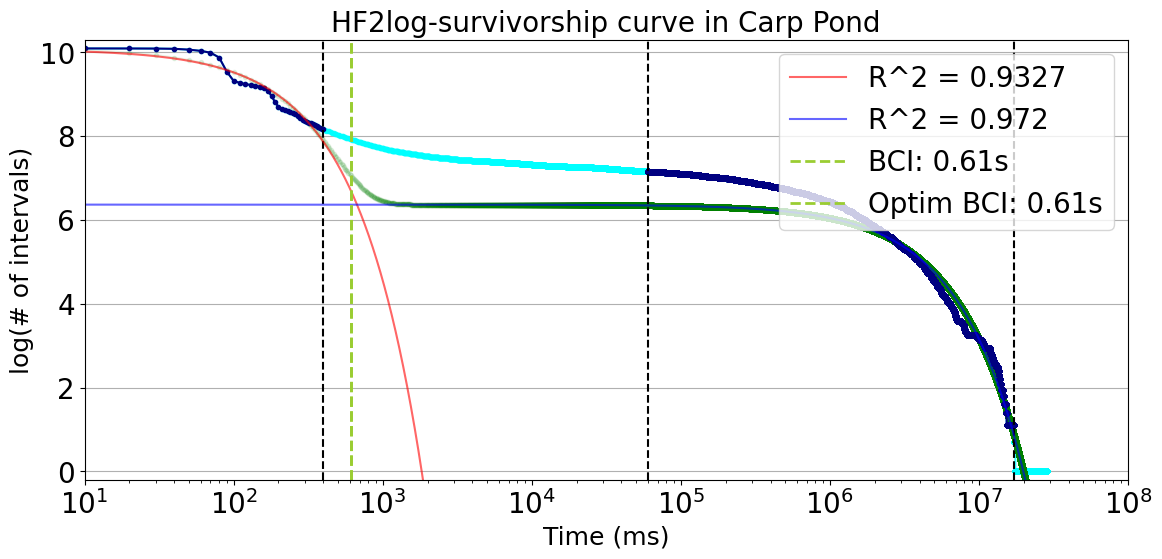

In [13]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = group

bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], nlin_results['bci'], fig_details)

In [14]:
bout_params = bt_clustering.get_bout_params_from_location(location_sum_df, data_params)
bout_params

{'site_key': 'Carp', 'freq_key': 'HF2', 'HF2_bci': 611.4066448848221}

In [15]:
batdetect2_predictions = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(location_sum_df, bout_params)
batdetect2_predictions[:15]

call_status  change_markers  bout_tag  duration_from_last_call_ms  \
0   outside bout             0.0         0                6.114066e+02   
1   outside bout             0.0         0                1.522837e+06   
2   outside bout             0.0         0                5.814905e+06   
3   outside bout             0.0         0                1.285820e+04   
4   outside bout             0.0         0                2.319636e+05   
5   outside bout             0.0         0                4.277100e+04   
6   outside bout             0.0         0                1.578490e+04   
7   outside bout             0.0         0                5.580500e+03   
8   outside bout             0.0         0                7.634876e+05   
9   outside bout             0.0         0                5.349889e+06   
10    bout start             1.0         0                1.405526e+06   
11   within bout             0.0         1                6.930000e+01   
12   within bout             0.0         1                2.871000e+02   
13      bout end            -1.0         1                2.800000e+02   
14  outside bout             0.0         0                4.070973e+05   

    start_time_wrt_ref  end_time_wrt_ref freq_group            ref_time  \
0             641.5785          641.5831        HF2 2022-07-13 05:00:00   
1             364.4205          364.4268        HF2 2022-07-13 05:30:00   
2             779.3315          779.3453        HF2 2022-07-13 07:00:00   
3             792.2035          792.2149        HF2 2022-07-13 07:00:00   
4            1024.1785         1024.1915        HF2 2022-07-13 07:00:00   
5            1066.9625         1066.9736        HF2 2022-07-13 07:00:00   
6            1082.7585         1082.7740        HF2 2022-07-13 07:00:00   
7            1088.3545         1088.3669        HF2 2022-07-13 07:00:00   
8              51.8545           51.8655        HF2 2022-07-13 07:30:00   
9               1.7545            1.7648        HF2 2022-07-13 09:00:00   
10           1407.2905         1407.2952        HF2 2022-07-13 09:00:00   
11           1407.3645         1407.3694        HF2 2022-07-13 09:00:00   
12           1407.6565         1407.6605        HF2 2022-07-13 09:00:00   
13           1407.9405         1407.9452        HF2 2022-07-13 09:00:00   
14             15.0425           15.0472        HF2 2022-07-13 09:30:00   

              call_start_time              call_end_time  ...  high_freq  \
0  2022-07-13 05:10:41.578500 2022-07-13 05:10:41.583100  ...    60637.0   
1  2022-07-13 05:36:04.420500 2022-07-13 05:36:04.426800  ...    49460.0   
2  2022-07-13 07:12:59.331500 2022-07-13 07:12:59.345300  ...    56523.0   
3  2022-07-13 07:13:12.203500 2022-07-13 07:13:12.214900  ...    58426.0   
4  2022-07-13 07:17:04.178500 2022-07-13 07:17:04.191500  ...    55614.0   
5  2022-07-13 07:17:46.962500 2022-07-13 07:17:46.973600  ...    56930.0   
6  2022-07-13 07:18:02.758500 2022-07-13 07:18:02.774000  ...    57231.0   
7  2022-07-13 07:18:08.354500 2022-07-13 07:18:08.366900  ...    57935.0   
8  2022-07-13 07:30:51.854500 2022-07-13 07:30:51.865500  ...    57767.0   
9  2022-07-13 09:00:01.754500 2022-07-13 09:00:01.764800  ...    56607.0   
10 2022-07-13 09:23:27.290500 2022-07-13 09:23:27.295200  ...    67267.0   
11 2022-07-13 09:23:27.364500 2022-07-13 09:23:27.369400  ...    68711.0   
12 2022-07-13 09:23:27.656500 2022-07-13 09:23:27.660500  ...    63109.0   
13 2022-07-13 09:23:27.940500 2022-07-13 09:23:27.945200  ...    60393.0   
14 2022-07-13 09:30:15.042500 2022-07-13 09:30:15.047200  ...    55764.0   

           event                      class  class_prob det_prob individual  \
0   Echolocation  Pipistrellus pipistrellus       0.221    0.590         -1   
1   Echolocation      Pipistrellus nathusii       0.528    0.584         -1   
2   Echolocation      Pipistrellus pygmaeus       0.502    0.534         -1   
3   Echolocation      Pipistrellus pygmaeus       0.570    0.586         -1   
4   Ech

In [16]:
bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_predictions)

time_on = int(dc_tag.split('of')[0])

bt_clustering.test_bout_end_times_in_period(bout_metrics, time_on)

In [17]:
bout_metrics

freq_group         start_time_of_bout           end_time_of_bout  \
0           HF2 2022-07-13 09:23:27.290500 2022-07-13 09:23:27.945200   
1           HF2 2022-07-14 06:26:19.628500 2022-07-14 06:26:21.081300   
2           HF2 2022-07-14 09:29:30.830500 2022-07-14 09:29:32.238000   
3           HF2 2022-07-15 08:16:15.455500 2022-07-15 08:16:17.554500   
4           HF2 2022-07-15 08:45:47.248500 2022-07-15 08:45:49.513200   
...         ...                        ...                        ...   
1660        HF2 2022-10-17 06:58:07.291500 2022-10-17 06:58:09.610200   
1661        HF2 2022-10-17 07:39:03.004500 2022-10-17 07:39:03.468500   
1662        HF2 2022-10-17 07:39:04.282500 2022-10-17 07:39:05.694200   
1663        HF2 2022-10-17 07:39:06.460500 2022-10-17 07:39:08.725300   
1664        HF2 2022-10-17 11:44:38.145500 2022-10-17 11:44:40.472500   

      start_time_wrt_ref  end_time_wrt_ref  start_time   end_time  low_freq  \
0              1407.2905         1407.9452   1407.2905  1407.9452   45234.0   
1              1579.6285         1581.0813   1579.6285  1581.0813   42656.0   
2              1770.8305         1772.2380   1770.8305  1772.2380   44375.0   
3               975.4555          977.5545    975.4555   977.5545   44375.0   
4               947.2485          949.5132    947.2485   949.5132   43515.0   
...                  ...               ...         ...        ...       ...   
1660           1687.2915         1689.6102   1687.2915  1689.6102   46953.0   
1661            543.0045          543.4685    543.0045   543.4685   43515.0   
1662            544.2825          545.6942    544.2825   545.6942   42656.0   
1663            546.4605          548.7253    546.4605   548.7253   42656.0   
1664            878.1455          880.4725    878.1455   880.4725   43515.0   

      high_freq          bout_duration  bout_duration_in_secs  
0       68711.0 0 days 00:00:00.654700                 0.6547  
1       57921.0 0 days 00:00:01.452800                 1.4528  
2       68867.0 0 days 00:00:01.407500                 1.4075  
3       64624.0 0 days 00:00:02.099000                 2.0990  
4       69619.0 0 days 00:00:02.264700                 2.2647  
...         ...                    ...                    ...  
1660    67109.0 0 days 00:00:02.318700                 2.3187  
1661    58237.0 0 days 00:00:00.464000                 0.4640  
1662    68811.0 0 days 00:00:01.411700                 1.4117  
1663    66721.0 0 days 00:00:02.264800                 2.2648  
1664    65266.0 0 days 00:00:02.327000                 2.3270  

[1665 rows x 11 columns]

In [18]:
bout_metrics = bt_clustering.generate_bout_metrics_for_location_and_freq(location_df, data_params, dc_tag)
bout_metrics

freq_group         start_time_of_bout           end_time_of_bout  \
0           HF2 2022-07-13 09:23:27.290500 2022-07-13 09:23:27.945200   
1           HF2 2022-07-14 06:26:19.628500 2022-07-14 06:26:21.081300   
2           HF2 2022-07-14 09:29:30.830500 2022-07-14 09:29:32.238000   
3           HF2 2022-07-15 08:16:15.455500 2022-07-15 08:16:17.554500   
4           HF2 2022-07-15 08:45:47.248500 2022-07-15 08:45:49.513200   
...         ...                        ...                        ...   
1660        HF2 2022-10-17 06:58:07.291500 2022-10-17 06:58:09.610200   
1661        HF2 2022-10-17 07:39:03.004500 2022-10-17 07:39:03.468500   
1662        HF2 2022-10-17 07:39:04.282500 2022-10-17 07:39:05.694200   
1663        HF2 2022-10-17 07:39:06.460500 2022-10-17 07:39:08.725300   
1664        HF2 2022-10-17 11:44:38.145500 2022-10-17 11:44:40.472500   

      start_time_wrt_ref  end_time_wrt_ref  start_time   end_time  low_freq  \
0              1407.2905         1407.9452   1407.2905  1407.9452   45234.0   
1              1579.6285         1581.0813   1579.6285  1581.0813   42656.0   
2              1770.8305         1772.2380   1770.8305  1772.2380   44375.0   
3               975.4555          977.5545    975.4555   977.5545   44375.0   
4               947.2485          949.5132    947.2485   949.5132   43515.0   
...                  ...               ...         ...        ...       ...   
1660           1687.2915         1689.6102   1687.2915  1689.6102   46953.0   
1661            543.0045          543.4685    543.0045   543.4685   43515.0   
1662            544.2825          545.6942    544.2825   545.6942   42656.0   
1663            546.4605          548.7253    546.4605   548.7253   42656.0   
1664            878.1455          880.4725    878.1455   880.4725   43515.0   

      high_freq          bout_duration  bout_duration_in_secs  
0       68711.0 0 days 00:00:00.654700                 0.6547  
1       57921.0 0 days 00:00:01.452800                 1.4528  
2       68867.0 0 days 00:00:01.407500                 1.4075  
3       64624.0 0 days 00:00:02.099000                 2.0990  
4       69619.0 0 days 00:00:02.264700                 2.2647  
...         ...                    ...                    ...  
1660    67109.0 0 days 00:00:02.318700                 2.3187  
1661    58237.0 0 days 00:00:00.464000                 0.4640  
1662    68811.0 0 days 00:00:01.411700                 1.4117  
1663    66721.0 0 days 00:00:02.264800                 2.2648  
1664    65266.0 0 days 00:00:02.327000                 2.3270  

[1665 rows x 11 columns]

In [19]:
dc_bouts = dh.construct_activity_arr_from_bout_metrics(bout_metrics, data_params, file_paths, dc_tag)
dc_bouts = dc_bouts.set_index("Date_and_Time_UTC")

In [20]:
def construct_activity_arr_from_bout_metrics(bout_metrics, data_params, file_paths, dc_tag):
    all_processed_filepaths = sorted(list(map(str, list(Path(f'{file_paths["raw_SITE_folder"]}').glob('*.csv')))))
    all_processed_datetimes = pd.to_datetime(all_processed_filepaths, format="%Y%m%d_%H%M%S", exact=False)

    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bout_metrics['total_bout_duration_in_secs'] = bout_metrics['bout_duration_in_secs']
    bout_metrics = bout_metrics.set_index('ref_time')

    bout_duration_per_interval = bout_metrics.resample(f"{data_params['resolution_in_min']}T")['total_bout_duration_in_secs'].sum()

    time_occupied_by_bouts  = bout_duration_per_interval.values
    percent_time_occupied_by_bouts = (100*(time_occupied_by_bouts / (60*float(data_params['resolution_in_min']))))

    bout_dpi_df = pd.DataFrame(list(zip(bout_duration_per_interval.index, time_occupied_by_bouts)), columns=['ref_time', f'percentage_time_occupied_by_bouts ({dc_tag})'])
    bout_dpi_df = bout_dpi_df.set_index('ref_time')
    bout_dpi_df = bout_dpi_df.reindex(index=all_processed_datetimes, fill_value=0).resample(f"{data_params['resolution_in_min']}T").first().between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

    return pd.DataFrame(list(zip(bout_dpi_df.index, bout_dpi_df[f'percentage_time_occupied_by_bouts ({dc_tag})'].values)), columns=["Date_and_Time_UTC", f'percentage_time_occupied_by_bouts ({dc_tag})'])

def generate_bout_metrics_for_location_and_freq(location_sum_df, data_params, dc_tag):

    location_sum_df.reset_index(inplace=True)
    if 'index' in location_sum_df.columns:
        location_sum_df.drop(columns='index', inplace=True)
    resampled_df = location_sum_df.resample(f'1800S', on='ref_time')
    location_sum_df['ref_time'] = resampled_df['ref_time'].transform(lambda x: x.name)

    bout_params = bt_clustering.get_bout_params_from_location(location_sum_df, data_params)

    batdetect2_predictions = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(location_sum_df, bout_params)
    bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_predictions)

    time_on = int(dc_tag.split('of')[0])

    bt_clustering.test_bout_end_times_in_period(bout_metrics, time_on)

    return bout_metrics

In [43]:
activity_bouts_arr = pd.DataFrame()

dc_tag = '1800of1800'
location_df_c = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
freq_groups = location_df_c['freq_group'].unique()
assert(len(freq_groups)==1 and freq_groups[0] == 'HF2')
bout_metrics_c = bt_clustering.generate_bout_metrics_for_location_and_freq(location_df_c, data_params, dc_tag)
time_cond = np.logical_and((pd.DatetimeIndex(bout_metrics_c['start_time_of_bout']).time >= dt.time(7, 0, 0)),
                           (pd.DatetimeIndex(bout_metrics_c['start_time_of_bout']).time <= dt.time(7, 30, 0)))
datetime_cond = np.logical_and((pd.DatetimeIndex(bout_metrics_c['start_time_of_bout']).date == dt.date(2022, 8, 3)), time_cond)
bout_metrics_c.loc[datetime_cond]

freq_group         start_time_of_bout        end_time_of_bout  \
287        HF2 2022-08-03 07:02:43.251500 2022-08-03 07:02:48.806   

     start_time_wrt_ref  end_time_wrt_ref  start_time  end_time  low_freq  \
287            163.2515           168.806    163.2515   168.806   43515.0   

     high_freq          bout_duration  bout_duration_in_secs  
287    64885.0 0 days 00:00:05.554500                 5.5545

In [46]:
dc_tag = '300of1800'
location_df_dc1 = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
freq_groups = location_df_dc1['freq_group'].unique()
assert(len(freq_groups)==1 and freq_groups[0] == 'HF2')
bout_metrics_dc1 = bt_clustering.generate_bout_metrics_for_location_and_freq(location_df_dc1, data_params, dc_tag)
time_cond = np.logical_and((pd.DatetimeIndex(bout_metrics_dc1['start_time_of_bout']).time >= dt.time(7, 0, 0)),
                           (pd.DatetimeIndex(bout_metrics_dc1['start_time_of_bout']).time <= dt.time(7, 30, 0)))
datetime_cond = np.logical_and((pd.DatetimeIndex(bout_metrics_dc1['start_time_of_bout']).date == dt.date(2022, 8, 3)), time_cond)
bout_metrics_dc1.loc[datetime_cond]

freq_group         start_time_of_bout        end_time_of_bout  \
20        HF2 2022-08-03 07:02:43.251500 2022-08-03 07:02:48.806   

    start_time_wrt_ref  end_time_wrt_ref  start_time  end_time  low_freq  \
20            163.2515           168.806    163.2515   168.806   43515.0   

    high_freq          bout_duration  bout_duration_in_secs  
20    64885.0 0 days 00:00:05.554500                 5.5545

In [47]:
dc_tag = '60of360'
location_df_dc2 = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
freq_groups = location_df_dc2['freq_group'].unique()
assert(len(freq_groups)==1 and freq_groups[0] == 'HF2')
bout_metrics_dc2 = generate_bout_metrics_for_location_and_freq(location_df_dc2, data_params, dc_tag)
time_cond = np.logical_and((pd.DatetimeIndex(bout_metrics_dc2['start_time_of_bout']).time >= dt.time(7, 0, 0)),
                           (pd.DatetimeIndex(bout_metrics_dc2['start_time_of_bout']).time <= dt.time(7, 30, 0)))
datetime_cond = np.logical_and((pd.DatetimeIndex(bout_metrics_dc2['start_time_of_bout']).date == dt.date(2022, 8, 3)), time_cond)
bout_metrics_dc2.loc[datetime_cond]

Empty DataFrame
Columns: [freq_group, start_time_of_bout, end_time_of_bout, start_time_wrt_ref, end_time_wrt_ref, start_time, end_time, low_freq, high_freq, bout_duration, bout_duration_in_secs]
Index: []

In [9]:
activity_bouts_arr = pd.DataFrame()

for dc_tag in data_params['dc_tags']:

    location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
    bout_metrics = bt_clustering.generate_bout_metrics_for_location_and_freq(location_df, data_params, dc_tag)
    dc_bouts = dh.construct_activity_arr_from_bout_metrics(bout_metrics, data_params, file_paths, dc_tag)
    dc_bouts = dc_bouts.set_index("Date_and_Time_UTC")
    activity_bouts_arr = pd.concat([activity_bouts_arr, dc_bouts], axis=1)

In [10]:
activity_bouts_arr.loc[activity_bouts_arr.index.date == dt.date(2022, 8, 3)]

percentage_time_occupied_by_bouts (1800of1800)  \
Date_and_Time_UTC                                                     
2022-08-03 02:00:00                                        0.000000   
2022-08-03 02:30:00                                        0.000000   
2022-08-03 03:00:00                                        0.000000   
2022-08-03 03:30:00                                        0.000000   
2022-08-03 04:00:00                                        0.000000   
2022-08-03 04:30:00                                        0.005733   
2022-08-03 05:00:00                                        0.047844   
2022-08-03 05:30:00                                        0.282056   
2022-08-03 06:00:00                                        0.000000   
2022-08-03 06:30:00                                        0.000000   
2022-08-03 07:00:00                                        0.308583   
2022-08-03 07:30:00                                        0.000000   
2022-08-03 08:00:00                                        0.114822   
2022-08-03 08:30:00                                        0.000000   
2022-08-03 09:00:00                                        0.000000   
2022-08-03 09:30:00                                        0.000000   
2022-08-03 10:00:00                                        0.000000   
2022-08-03 10:30:00                                        0.000000   
2022-08-03 11:00:00                                        0.279000   
2022-08-03 11:30:00                                        0.118622   
2022-08-03 12:00:00                                        0.000000   
2022-08-03 12:30:00                                        0.000000   
2022-08-03 13:00:00                                        0.000000   

                     percentage_time_occupied_by_bouts (300of1800)  \
Date_and_Time_UTC                                                    
2022-08-03 02:00:00                                       0.000000   
2022-08-03 02:30:00                                       0.000000   
2022-08-03 03:00:00                                       0.000000   
2022-08-03 03:30:00                                       0.000000   
2022-08-03 04:00:00                                       0.000000   
2022-08-03 04:30:00                                       0.005733   
2022-08-03 05:00:00                                       0.012533   
2022-08-03 05:30:00                                       0.282056   
2022-08-03 06:00:00                                       0.000000   
2022-08-03 06:30:00                                       0.000000   
2022-08-03 07:00:00                                       0.308583   
2022-08-03 07:30:00                                       0.000000   
2022-08-03 08:00:00                                       0.000000   
2022-08-03 08:30:00                                       0.000000   
2022-08-03 09:00:00                                       0.000000   
2022-08-03 09:30:00                                       0.000000   
2022-08-03 10:00:00                                       0.000000   
2022-08-03 10:30:00                                       0.000000   
2022-08-03 11:00:00                                       0.000000   
2022-08-03 11:30:00                                       0.000000   
2022-08-03 12:00:00                                       0.000000   
2022-08-03 12:30:00                                       0.000000   
2022-08-03 13:00:00                                       0.000000   

                     percentage_time_occupied_by_bouts (60of360)  
Date_and_Time_UTC                                                 
2022-08-03 02:00:00                                     0.000000  
2022-08-03 02:30:00                                     0.000000  
2022-08-03 03:00:00                                     0.000000  
2022-08-03 03:30:00                                     0.000000  
2022-08-03 04:00:00                                     0.000000  
2022-08-03 04:30:00      

In [11]:
continuous_column = ''
for column in activity_bouts_arr.columns:
    if ('1800of1800') in column:
        continuous_column = column

continuous_metrics = activity_bouts_arr[continuous_column].dropna()
continuous_metrics

Date_and_Time_UTC
2022-07-13 02:00:00    0.000000
2022-07-13 02:30:00    0.000000
2022-07-13 03:00:00    0.000000
2022-07-13 03:30:00    0.000000
2022-07-13 04:00:00    0.000000
                         ...   
2022-10-17 11:00:00    0.000000
2022-10-17 11:30:00    0.129278
2022-10-17 12:00:00    0.000000
2022-10-17 12:30:00    0.000000
2022-10-17 13:00:00    0.000000
Name: percentage_time_occupied_by_bouts (1800of1800), Length: 2069, dtype: float64

In [12]:
# for column in activity_bouts_arr.columns:
columns = activity_bouts_arr.columns[2]
dc_metrics = activity_bouts_arr[column].dropna()
dc_metrics

Date_and_Time_UTC
2022-07-13 02:00:00    0.0
2022-07-13 02:30:00    0.0
2022-07-13 03:00:00    0.0
2022-07-13 03:30:00    0.0
2022-07-13 04:00:00    0.0
                      ... 
2022-10-17 11:00:00    0.0
2022-10-17 11:30:00    0.0
2022-10-17 12:00:00    0.0
2022-10-17 12:30:00    0.0
2022-10-17 13:00:00    0.0
Name: percentage_time_occupied_by_bouts (60of360), Length: 2069, dtype: float64

In [42]:
assertion = (dc_metrics<=continuous_metrics).values
np.where(assertion==False)[0]

array([], dtype=int64)

## As shown below, duty-cycled bout length is NOT always less than continuous bout length. This is because we calculate the BCI based off the subsampled results. So the BCI can be longer or shorter than the continious BCI, this may create longer or shorter bouts observed from duty-cycled data

In [29]:
(activity_bouts_arr.dropna()).iloc[np.where(assertion==False)[0]]

Empty DataFrame
Columns: [percentage_time_occupied_by_bouts (1800of1800), percentage_time_occupied_by_bouts (300of1800), percentage_time_occupied_by_bouts (60of360)]
Index: []

In [13]:
activity_bouts_arr.loc[activity_bouts_arr.index.date == dt.date(2022, 8, 3)]

percentage_time_occupied_by_bouts (1800of1800)  \
Date_and_Time_UTC                                                     
2022-08-03 02:00:00                                        0.000000   
2022-08-03 02:30:00                                        0.000000   
2022-08-03 03:00:00                                        0.000000   
2022-08-03 03:30:00                                        0.000000   
2022-08-03 04:00:00                                        0.000000   
2022-08-03 04:30:00                                        0.005733   
2022-08-03 05:00:00                                        0.047844   
2022-08-03 05:30:00                                        0.282056   
2022-08-03 06:00:00                                        0.000000   
2022-08-03 06:30:00                                        0.000000   
2022-08-03 07:00:00                                        0.308583   
2022-08-03 07:30:00                                        0.000000   
2022-08-03 08:00:00                                        0.114822   
2022-08-03 08:30:00                                        0.000000   
2022-08-03 09:00:00                                        0.000000   
2022-08-03 09:30:00                                        0.000000   
2022-08-03 10:00:00                                        0.000000   
2022-08-03 10:30:00                                        0.000000   
2022-08-03 11:00:00                                        0.279000   
2022-08-03 11:30:00                                        0.118622   
2022-08-03 12:00:00                                        0.000000   
2022-08-03 12:30:00                                        0.000000   
2022-08-03 13:00:00                                        0.000000   

                     percentage_time_occupied_by_bouts (300of1800)  \
Date_and_Time_UTC                                                    
2022-08-03 02:00:00                                       0.000000   
2022-08-03 02:30:00                                       0.000000   
2022-08-03 03:00:00                                       0.000000   
2022-08-03 03:30:00                                       0.000000   
2022-08-03 04:00:00                                       0.000000   
2022-08-03 04:30:00                                       0.005733   
2022-08-03 05:00:00                                       0.012533   
2022-08-03 05:30:00                                       0.282056   
2022-08-03 06:00:00                                       0.000000   
2022-08-03 06:30:00                                       0.000000   
2022-08-03 07:00:00                                       0.308583   
2022-08-03 07:30:00                                       0.000000   
2022-08-03 08:00:00                                       0.000000   
2022-08-03 08:30:00                                       0.000000   
2022-08-03 09:00:00                                       0.000000   
2022-08-03 09:30:00                                       0.000000   
2022-08-03 10:00:00                                       0.000000   
2022-08-03 10:30:00                                       0.000000   
2022-08-03 11:00:00                                       0.000000   
2022-08-03 11:30:00                                       0.000000   
2022-08-03 12:00:00                                       0.000000   
2022-08-03 12:30:00                                       0.000000   
2022-08-03 13:00:00                                       0.000000   

                     percentage_time_occupied_by_bouts (60of360)  
Date_and_Time_UTC                                                 
2022-08-03 02:00:00                                     0.000000  
2022-08-03 02:30:00                                     0.000000  
2022-08-03 03:00:00                                     0.000000  
2022-08-03 03:30:00                                     0.000000  
2022-08-03 04:00:00                                     0.000000  
2022-08-03 04:30:00      

In [14]:
activity_df = dh.construct_activity_grid_for_bouts(activity_bouts_arr, data_params['cur_dc_tag'])

In [15]:
activity_df['08/03/22']

Time (UTC)
02:00    0.000000
02:30    0.000000
03:00    0.000000
03:30    0.000000
04:00    0.000000
04:30    0.005733
05:00    0.047844
05:30    0.282056
06:00    0.000000
06:30    0.000000
07:00    0.308583
07:30    0.000000
08:00    0.114822
08:30    0.000000
09:00    0.000000
09:30    0.000000
10:00    0.000000
10:30    0.000000
11:00    0.279000
11:30    0.118622
12:00    0.000000
12:30    0.000000
13:00    0.000000
Name: 08/03/22, dtype: float64

In [35]:
activity_bouts_arr = pipeline.run_for_bouts(data_params, pipeline_params, file_paths)

In [16]:
activity_df['08/03/22']

Time (UTC)
02:00    0.000000
02:30    0.000000
03:00    0.000000
03:30    0.000000
04:00    0.000000
04:30    0.005733
05:00    0.047844
05:30    0.282056
06:00    0.000000
06:30    0.000000
07:00    0.308583
07:30    0.000000
08:00    0.114822
08:30    0.000000
09:00    0.000000
09:30    0.000000
10:00    0.000000
10:30    0.000000
11:00    0.279000
11:30    0.118622
12:00    0.000000
12:30    0.000000
13:00    0.000000
Name: 08/03/22, dtype: float64

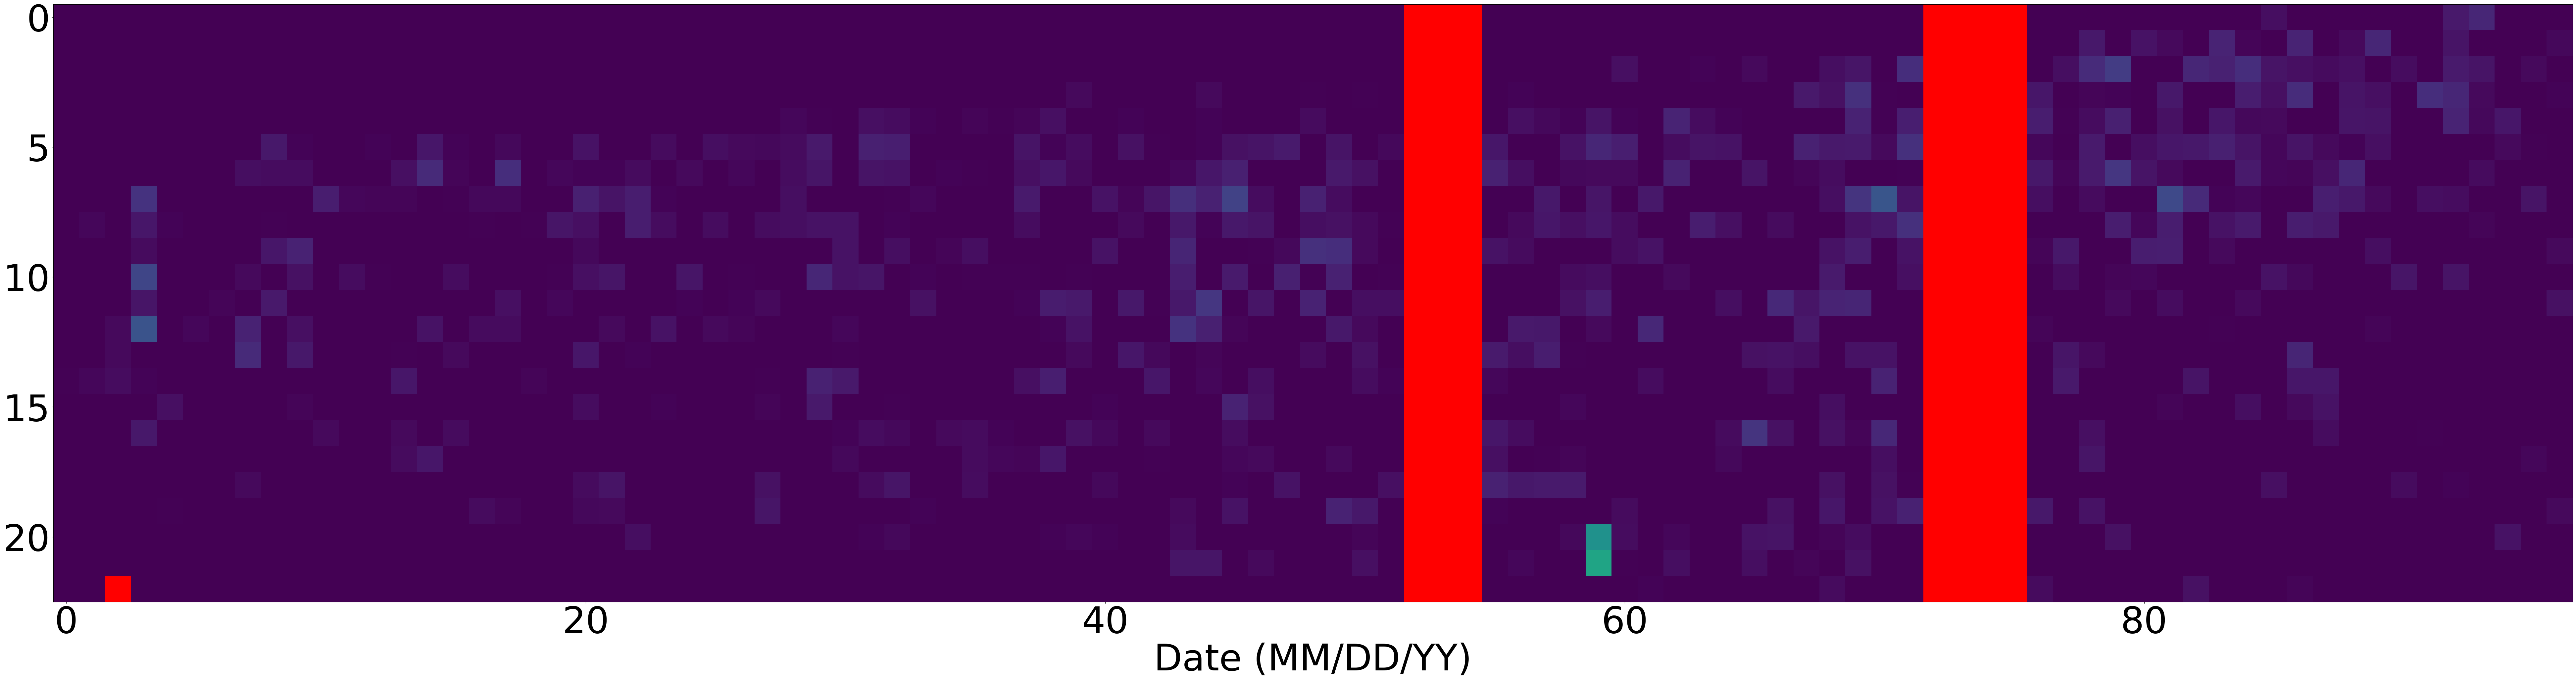

In [71]:
on = int(data_params['cur_dc_tag'].split('of')[0])
total = int(data_params['cur_dc_tag'].split('of')[1])
recover_ratio = total / on

masked_array_for_nodets = np.ma.masked_where(activity_df.values==np.NaN, activity_df.values)
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='red')

plt.rcParams.update({'font.size': (80)})
plt.figure(figsize=(80, 40))
plt.imshow(1+(recover_ratio*masked_array_for_nodets), cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=100))
plt.xlabel('Date (MM/DD/YY)')
plt.tight_layout()
if pipeline_params["show_plots"]:
    plt.show()

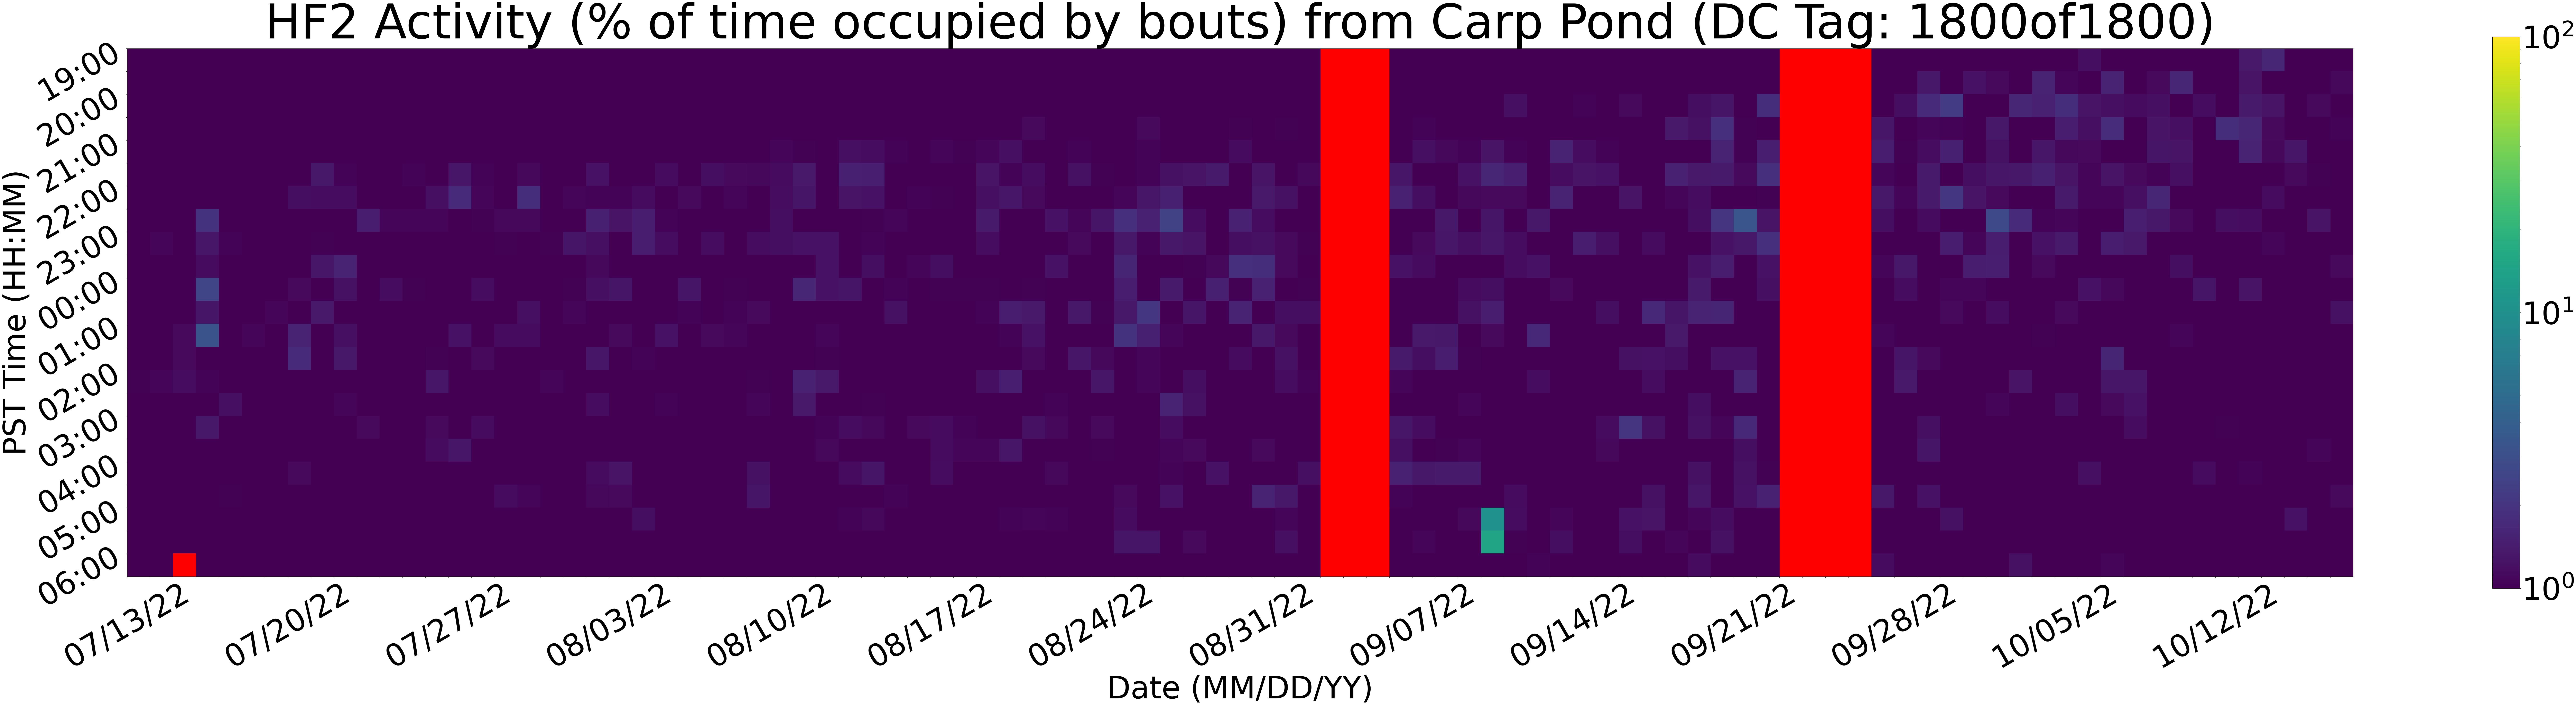

In [15]:
plotting.plot_activity_grid_for_bouts(dh.construct_activity_grid_for_bouts(activity_bouts_arr, data_params['cur_dc_tag']), data_params, pipeline_params, file_paths)
# plotting.plot_dc_bouts_comparisons_per_night(activity_bouts_arr, data_params, pipeline_params, file_paths)

In [17]:
plotting.plot_dc_bout_activity_comparisons_per_scheme(activity_bouts_arr, data_params, pipeline_params, file_paths)

In [ ]:
# pipeline.plot_bouts(activity_bouts_arr, data_params, pipeline_params, file_paths)

In [ ]:
# pipeline.compare_bout_and_det_metrics(data_params, pipeline_params, file_paths)